fl: flip <br>
ro: rotation <br>
no: normalization

In [4]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from collections import Counter
from copy import deepcopy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from skimage import io
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
from torchvision import models
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

use_model = 'resnet152'
this_file = 'ResNet152_Focal_Loss_Top700'

if use_model == '': use_model = 'a'
if this_file == '': this_file = 'a'

# data_path = "~/Datasets/iMet_Colelction_2019"
# load_path = "../input/"
load_path = "/home/sano/Datasets/iMet_Colelction_2019/input/"

log_dir = 'runs/' + this_file
weight_path = './model_weight/' + use_model + '/' + this_file


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

print('log_dir = ', log_dir)
print('weight save path = ', weight_path)
# 複数GPU使用宣言
# if device == 'cuda:1':
#     net = torch.nn.DataParallel(net) # make parallel
#     cudnn.benchmark = True


torch.manual_seed(823)

device cuda
log_dir =  runs/ResNet152_Focal_Loss_Top700
weight save path =  ./model_weight/resnet152/ResNet152_Focal_Loss_Top700


In [5]:
batch_size = 10
num_classes = 1103
epochs = 50
extract_attribute = 5 # 予測した上位何個を属性として出力するか

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [7]:
class iMetsDataset(data.Dataset):
 
    def __init__(self, df, root_dir, transform=None, mode='train'):
        """
        Args:
            df (dataframe): ファイル名がindex、Nhot_LabelsカラムにNhot化したラベルを格納したDataframe
            root_dir (string): 対象の画像ファイルが入っているフォルダ
            transform (callable, optional): 施す変換
        """
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
 
    def __len__(self):
        return len(self.df)
 
    def __getitem__(self, idx):
#         if type(idx) == torch.Tensor:
#             idx = idx.item()
        img_name = os.path.join(self.root_dir, self.df.index[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
            
        if self.mode == 'train':
            label = self.df.iloc[idx].Nhot_Labels_TopN.astype('float32')
            return image, label
        else:
            return image
    
def Nhot_encoding(arr, l):
    """
    Nhotエンコーディングを行う

    Parameters
    ----------
    arr : ndarray
        ラベル
    l : int
        総ラベル数
    """
    if arr.ndim == 1:
        ret = np.zeros(l,dtype='int')
        if len(arr) != 0:
            ret[arr] = 1
        return ret
    else:
        lst = list()
        for i,_ in enumerate(arr):
            lst.extend([i] * arr.shape[1])
            
        ret = np.zeros((arr.shape[0],l),dtype='int')
        ret[lst,arr.flatten()] = 1
        return ret

データ呼び出し

In [8]:
label_name = pd.read_csv(load_path + 'labels.csv')
label_name = label_name.set_index("attribute_id")
submit_df = pd.read_csv(load_path + 'sample_submission.csv')
submit_df["id"] = submit_df["id"].apply(lambda x: x + ".png")
submit_df = submit_df.set_index('id')
test_size = len(submit_df)

train_df = pd.read_csv(load_path + 'train.csv')
train_size = len(train_df)
train_df["attribute_ids"] = train_df["attribute_ids"].apply(lambda x: np.array([int(s) for s in x.split(" ")]))
train_df["Nhot_Labels"] = train_df["attribute_ids"].apply(lambda x: Nhot_encoding(x,1103))
train_df["id"] = train_df["id"].apply(lambda x: x + ".png")
train_df = train_df.set_index('id')

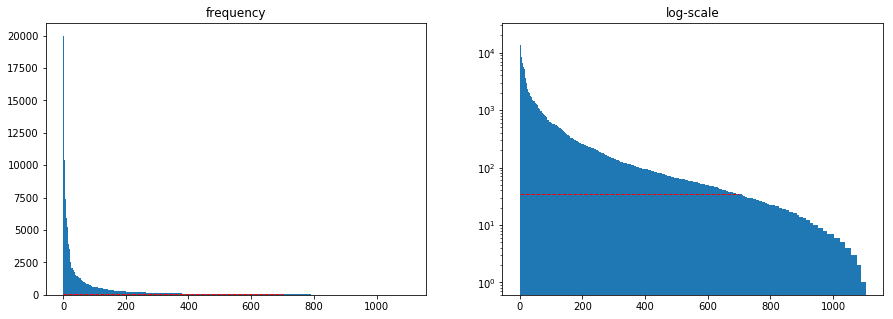

In [9]:
#上位何個取るか
take_num = 700

cnt_attribute = Counter()
for i in train_df.attribute_ids:
    cnt_attribute.update(i)

freq_attr = np.asarray(cnt_attribute.most_common(num_classes))

# plt.ylim(0,15000)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(range(1,len(freq_attr)+1),freq_attr[:,1],width=1)
plt.title("frequency")
plt.hlines(freq_attr[take_num-1][1], 0, take_num, 'red', linestyles='dashed', linewidth=1)

plt.subplot(1,2,2)
plt.bar(range(1,len(freq_attr)+1),freq_attr[:,1],width=1)
plt.hlines(freq_attr[take_num-1][1], 0, take_num, 'red', linestyles='dashed', linewidth=1)
plt.gca().set_yscale("log")
plt.title('log-scale')

freq_attr = np.asarray(cnt_attribute.most_common(take_num))
freq_set = set(freq_attr[:take_num,0])

plt.show()


sort_label_encode = {a:b for b,a in enumerate(freq_attr[:,0])}
sort_label_decode = {a:b for a,b in enumerate(freq_attr[:,0])}

train_df["attribute_ids_TopN"] = train_df["attribute_ids"].apply(lambda x:np.array([sort_label_encode[i] for i in x if i in freq_set]))
train_df["Nhot_Labels_TopN"] = train_df["attribute_ids_TopN"].apply(lambda x: Nhot_encoding(x, take_num))

In [10]:
torch.manual_seed(823)
np.random.seed(823)

ds_allTrain = iMetsDataset(train_df,load_path+'train',
                            transform = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            ]),
                        )

ds_train, ds_valid = data.random_split(ds_allTrain, [90000, 19237])

ds_test = iMetsDataset(submit_df,load_path+'test',
                            transform = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            ]),
                           mode='test'
                        )

if type(ds_train.indices) == torch.Tensor:
    ds_train.indices = ds_train.indices.numpy()
    ds_valid.indices = ds_valid.indices.numpy()


dataloader_train = data.DataLoader(dataset=ds_train,batch_size=batch_size,shuffle=True)
dataloader_valid = data.DataLoader(dataset=ds_valid,batch_size=batch_size,shuffle=False)
dataloader_test = data.DataLoader(dataset=ds_test,batch_size=batch_size,shuffle=False)

モデルを定義

In [11]:

torch.manual_seed(823)
np.random.seed(823)


resnet152 = models.resnet152(pretrained=True)

# Newly created modules have require_grad=True by default
num_features = resnet152.fc.in_features
features = list(resnet152.fc.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, take_num)]) # Add our layer
resnet152.fc = nn.Sequential(*features) # Replace the model classifier
# load weight
# resnet152.load_state_dict(torch.load('model_weight/resnet152/resnet152_FocalLoss_epoch7.pkl'))
model = resnet152.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/sano/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 112186496.53it/s]


In [12]:
# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss(gamma=2, logits=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train,eval,predictの定義

In [17]:
global_step = 0
def train(epoch, writer):
    start = time.time()
    model.train()
    steps = len(ds_train)//batch_size
    for step, (images, labels) in enumerate(dataloader_train, 1):
        global global_step
        global_step += 1
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if step % 150 == 0:
            elapsed_time = time.time() - start
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.10f, time: %d分%d秒' % (epoch, epochs, step, steps, loss.item(), elapsed_time//60, int(elapsed_time % 60)))
            writer.add_scalar('train/train_loss', loss.item() , global_step)

            
def eval(epoch, writer):
    start = time.time()
    model.eval()
    fbeta_lst = list()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader_valid):
            images, labels = images.to(device), labels.to(device)
            labels = labels.cpu().detach().numpy()
            outputs = torch.sigmoid(model(images))
            outputs = outputs.cpu().detach().numpy()
            outputs_topN = np.argsort(outputs, axis=1)[:,-extract_attribute:]
            outputs_topN_Nhots = Nhot_encoding(outputs_topN, take_num)
            fbeta_lst.append(fbeta_score(labels,outputs_topN_Nhots, beta=2 ,average='samples'))
            print('A')
    elapsed_time = time.time() - start
    print("Val Acc : %.10f, time: %d分%d秒" % (sum(fbeta_lst)/len(fbeta_lst), elapsed_time//60, int(elapsed_time % 60)))
    writer.add_scalar('eval/val_acc', sum(fbeta_lst)*100/len(fbeta_lst), epoch)
    

def predict():
    pred_attr = list()
    model.eval()
    with torch.no_grad():
        for i, images in enumerate(dataloader_test,1):
            images = images.to(device)
            outputs = torch.sigmoid(model(images))
            outputs = outputs.cpu().detach().numpy()
            outputs_topN = np.argsort(outputs, axis=1)[:,-extract_attribute:]
            for attr in outputs_topN:
                pred_attr.append(attr)
            if i % 10 == 0:
                sys.stdout.write('\r[%d/%d]' % (min((i * batch_size),test_size), test_size))
                sys.stdout.flush()
    return pred_attr          

In [11]:
torch.manual_seed(1)
writer = SummaryWriter(log_dir)
 
for epoch in range(1, epochs+1):
    train(epoch, writer)
    eval(epoch, writer)
    torch.save(model.state_dict(), weight_path + '_epoch' + str(epoch)+'.pkl')


writer.close()

/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [1/50], Step [150/9000], Loss: 0.0036927534, time: 1分25秒


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-2b4bc684397c>", line 5, in <module>
    train(epoch, writer)
  File "<ipython-input-10-89709d4d68bb>", line 6, in train
    for step, (images, labels) in enumerate(dataloader_train, 1):
  File "/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 560, in __next__
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 560, in <listcomp>
    batch = self.collate_fn([self.dataset[i] for i in indices])
  File "/home/sano/.pyenv/versions/anaconda3-5.3.1/envs/pytorch/lib/python3.7/site-packages/torch/utils/data/dataset.py", lin

KeyboardInterrupt: 

In [ ]:
# pred = predict()
# pred_str = list()
# for lst in pred:
#     pred_str.append(" ".join(list(map(str, lst))))

# submit_df.index = submit_df.index.map(lambda x:x.rstrip(".png"))
# submit_df.attribute_ids = pred_str

# submit_df.to_csv("submission.csv", index=True)